In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('airline_passengers.csv', parse_dates = ['Month'], index_col = ['Month'])
 
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


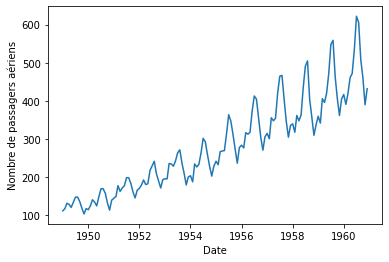

In [3]:
plt.xlabel('Date')
plt.ylabel('Nombre de passagers aériens')
plt.plot(df)

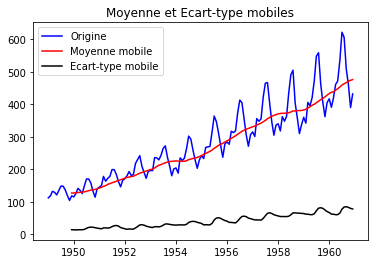

In [4]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

la moyenne mobile et l’écart-type mobile augmentent avec le temps. Nous pouvons donc conclure que la série temporelle n’est pas stationnaire.


In [5]:
result = adfuller(df['Thousands of Passengers'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : 0.8153688792060418
p-value : 0.9918802434376409
Valeurs Critiques :
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


La statistique ADF est loin des valeurs critiques et la p-value est supérieure au seuil (0,05). On peut donc conclure que la série temporelle n’est pas stationnaire.

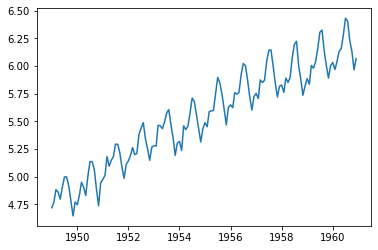

In [6]:
df_log = np.log(df)
plt.plot(df_log)

In [7]:
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries['Thousands of Passengers'])
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

Il existe de multiples transformations que nous pouvons appliquer à une série temporelle pour la rendre stationnaire. Par exemple, soustraire la moyenne mobile :

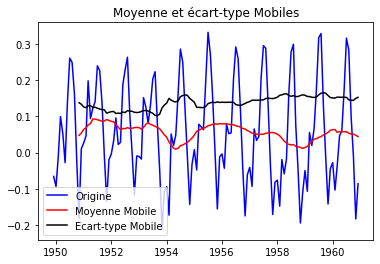

Statistiques ADF : -3.1629079913008504
p-value : 0.022234630001244333
Valeurs Critiques :
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [8]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

Après soustraction de la moyenne, la moyenne mobile et l’écart-type sont approximativement horizontaux. La p-value est inférieure au seuil de 0,05 et la statistique ADF est proche des valeurs critiques. Par conséquent, la série temporelle est stationnaire

L’application de la décroissance exponentielle est une autre façon de transformer une série temporelle de manière à ce qu’elle soit stationnaire :

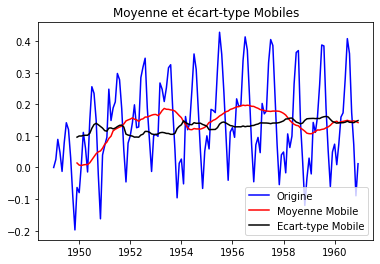

Statistiques ADF : -3.6012624201616865
p-value : 0.0057369388015117
Valeurs Critiques :
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [9]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

La décroissance exponentielle a été pire que la soustraction de la moyenne mobile. Cependant, elle est plus stationnaire que l’original.

Essayons une autre méthode pour déterminer s’il existe une solution encore meilleure. En appliquant le décalage temporel, nous soustrayons chaque point par celui qui l’a précédé.

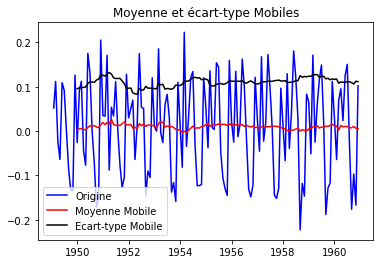

Statistiques ADF : -2.7171305983881044
p-value : 0.07112054815086355
Valeurs Critiques :
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


In [10]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

Le décalage temporel est moins bons que la soustraction de la moyenne mobile. Cependant, il est toujours plus stationnaire que l’original.


In [12]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

NotImplementedError: ignored

In [ ]:
fig = results.plot_predict(1,264)

----------------------------------------------------------

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’

In [13]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
new_df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(new_df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


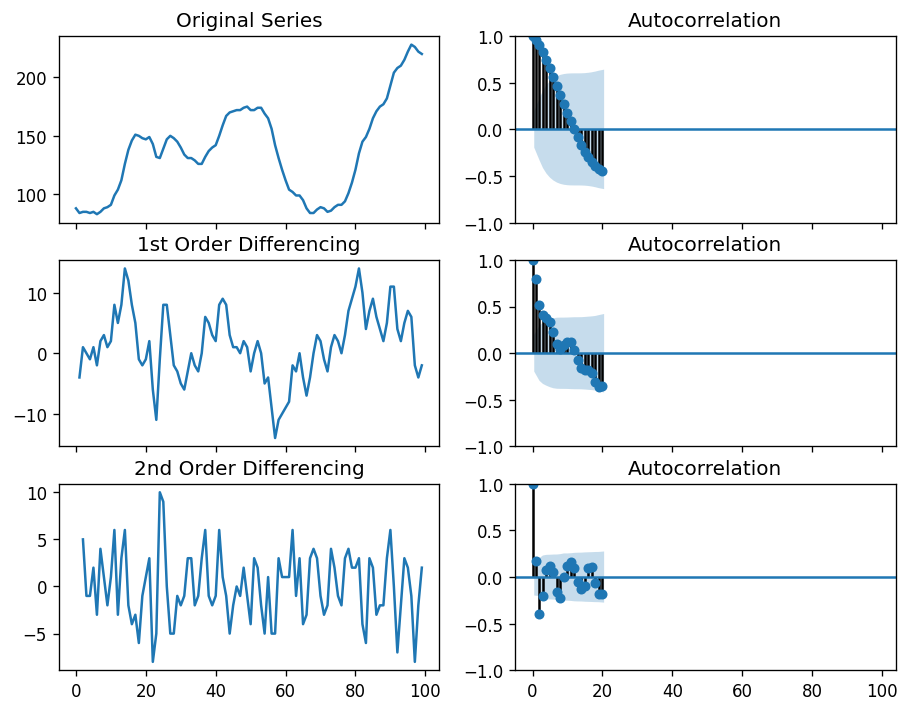

In [14]:

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(new_df.value); axes[0, 0].set_title('Original Series')
plot_acf(new_df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(new_df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(new_df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(new_df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(new_df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
pip install pmdarima

In [15]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value

## Adf Test
ndiffs(y, test='adf')  # 2

# KPSS test
ndiffs(y, test='kpss')  # 0

# PP test:
ndiffs(y, test='pp')  # 2

2